# Prepare Data

In [1]:
import pathlib
data_root = f"{pathlib.Path.home()}/Projects/AI-ML/datasets"

In [2]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(f"{data_root}/{path}")

names_path = 'nlp_data/names/*.txt'
# print(findFiles(names_path))

In [3]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [4]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles(names_path):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [5]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [6]:
letter2index = {l:i for (i, l) in enumerate(all_letters)}
letter2index

{'a': 0,
 'b': 1,
 'c': 2,
 'd': 3,
 'e': 4,
 'f': 5,
 'g': 6,
 'h': 7,
 'i': 8,
 'j': 9,
 'k': 10,
 'l': 11,
 'm': 12,
 'n': 13,
 'o': 14,
 'p': 15,
 'q': 16,
 'r': 17,
 's': 18,
 't': 19,
 'u': 20,
 'v': 21,
 'w': 22,
 'x': 23,
 'y': 24,
 'z': 25,
 'A': 26,
 'B': 27,
 'C': 28,
 'D': 29,
 'E': 30,
 'F': 31,
 'G': 32,
 'H': 33,
 'I': 34,
 'J': 35,
 'K': 36,
 'L': 37,
 'M': 38,
 'N': 39,
 'O': 40,
 'P': 41,
 'Q': 42,
 'R': 43,
 'S': 44,
 'T': 45,
 'U': 46,
 'V': 47,
 'W': 48,
 'X': 49,
 'Y': 50,
 'Z': 51,
 ' ': 52,
 '.': 53,
 ',': 54,
 ';': 55,
 "'": 56}

In [7]:
import torch

def name2tensor(name):
    return torch.tensor([letter2index[l] for l in name])

name2tensor('Dung').unsqueeze(0)

tensor([[29, 20, 13,  6]])

In [57]:
import torch.nn as nn
import torch.nn.functional as F


class RnnCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim) -> None:
        super().__init__()

        self.i2h = nn.Linear(input_dim + hidden_dim, hidden_dim, bias=True)
        self.h2o = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden):
        x = torch.cat((x, hidden), dim=-1)
        hidden = F.tanh(self.i2h(x))
        output = self.h2o(hidden)
        return output, hidden

class RnnClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_size, hidden_dim, output_dim) -> None:
        super().__init__()

        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.cell = RnnCell(embedding_size, hidden_dim, output_dim)
        self.softmax = nn.LogSoftmax(dim=-1)

    def step_forward(self, x, hidden):
        embedded = self.embedding(x).squeeze(-2)
        output, hidden = self.cell(embedded, hidden)
        return output, hidden

    def forward_batch(self, batch, hidden):
        outputs = []
        # inputs: (B, T)
        B, T = batch.size()
        if hidden is None:
            hidden = torch.zeros((B, self.hidden_dim))
        for t in range(T):
            output, hidden = self.step_forward(batch[:, t].unsqueeze(-1), hidden)
            outputs.append(output)
        return outputs, hidden

    def forward_single(self, x, hidden):
        outputs = []
        if hidden is None:
            hidden = torch.zeros(self.hidden_dim)
        for t in range(len(x)):
            output, hidden = self.step_forward(x[t].unsqueeze(-1), hidden)
            outputs.append(output)
        return outputs, hidden

    def forward(self, inputs, hidden=None):
        outputs = []
        if inputs.dim() == 2:
            outputs, hidden = self.forward_batch(inputs, hidden)
        else:
            outputs, hidden = self.forward_single(inputs, hidden)
        cl = self.softmax(outputs[-1])
        return cl, torch.stack(outputs, dim=-2), hidden



In [58]:
name2tensor('Dung').unsqueeze(0).dim()

2

In [62]:
rnn_net = RnnClassifier(len(all_letters), 20, 64, 10)

rnn_net(name2tensor('Dung'))

(tensor([-2.3454, -2.1946, -2.4561, -2.3224, -2.1760, -2.6006, -2.1566, -2.3622,
         -2.2667, -2.2288], grad_fn=<LogSoftmaxBackward0>),
 tensor([[-0.1065, -0.0234, -0.1333,  0.1506,  0.1707, -0.0149, -0.1050, -0.1151,
          -0.4469,  0.0016],
         [-0.1113,  0.1234, -0.0233,  0.2687, -0.0699, -0.1594,  0.0076,  0.3197,
          -0.0354,  0.2268],
         [ 0.0807,  0.0824,  0.0694,  0.1132, -0.1933, -0.1104,  0.0010, -0.0527,
          -0.0912,  0.3391],
         [-0.0990,  0.0518, -0.2097, -0.0761,  0.0704, -0.3543,  0.0898, -0.1158,
          -0.0203,  0.0176]], grad_fn=<StackBackward0>),
 tensor([ 0.0726, -0.3795,  0.0661,  0.0957,  0.2626, -0.1148,  0.0790, -0.1236,
          0.3079,  0.4043,  0.0149, -0.0900,  0.0318, -0.0378,  0.2422,  0.0083,
          0.3240,  0.1682,  0.1805, -0.0464,  0.2311, -0.0998, -0.1567, -0.0587,
          0.4685, -0.0760, -0.0234, -0.2116, -0.0711, -0.0486,  0.3079,  0.1468,
          0.1353, -0.2628, -0.0497,  0.0947, -0.4276, -0.3033, 

In [63]:
rnn_net(name2tensor('Dung').unsqueeze(0))

(tensor([[-2.3454, -2.1946, -2.4561, -2.3224, -2.1760, -2.6006, -2.1566, -2.3622,
          -2.2667, -2.2288]], grad_fn=<LogSoftmaxBackward0>),
 tensor([[[-0.1065, -0.0234, -0.1333,  0.1506,  0.1707, -0.0149, -0.1050,
           -0.1151, -0.4469,  0.0016],
          [-0.1113,  0.1234, -0.0233,  0.2687, -0.0699, -0.1594,  0.0076,
            0.3197, -0.0354,  0.2268],
          [ 0.0807,  0.0824,  0.0694,  0.1132, -0.1933, -0.1104,  0.0010,
           -0.0527, -0.0912,  0.3391],
          [-0.0990,  0.0518, -0.2097, -0.0761,  0.0704, -0.3543,  0.0898,
           -0.1158, -0.0203,  0.0176]]], grad_fn=<StackBackward0>),
 tensor([[ 0.0726, -0.3795,  0.0661,  0.0957,  0.2626, -0.1148,  0.0790, -0.1236,
           0.3079,  0.4043,  0.0149, -0.0900,  0.0318, -0.0378,  0.2422,  0.0083,
           0.3240,  0.1682,  0.1805, -0.0464,  0.2311, -0.0998, -0.1567, -0.0587,
           0.4685, -0.0760, -0.0234, -0.2116, -0.0711, -0.0486,  0.3079,  0.1468,
           0.1353, -0.2628, -0.0497,  0.0947, -

In [64]:
rnn_net(torch.stack((name2tensor('Dung'), name2tensor('Ahaa')), dim=0))

(tensor([[-2.3454, -2.1946, -2.4561, -2.3224, -2.1760, -2.6006, -2.1566, -2.3622,
          -2.2667, -2.2288],
         [-2.4081, -2.3536, -2.5791, -2.1136, -2.2651, -2.2273, -2.2680, -2.3214,
          -2.2664, -2.2891]], grad_fn=<LogSoftmaxBackward0>),
 tensor([[[-0.1065, -0.0234, -0.1333,  0.1506,  0.1707, -0.0149, -0.1050,
           -0.1151, -0.4469,  0.0016],
          [-0.1113,  0.1234, -0.0233,  0.2687, -0.0699, -0.1594,  0.0076,
            0.3197, -0.0354,  0.2268],
          [ 0.0807,  0.0824,  0.0694,  0.1132, -0.1933, -0.1104,  0.0010,
           -0.0527, -0.0912,  0.3391],
          [-0.0990,  0.0518, -0.2097, -0.0761,  0.0704, -0.3543,  0.0898,
           -0.1158, -0.0203,  0.0176]],
 
         [[ 0.1039, -0.0044,  0.1570, -0.2463, -0.1748, -0.0637, -0.1065,
           -0.2584, -0.1261,  0.3039],
          [-0.0704,  0.1341, -0.5069, -0.1216,  0.2731, -0.4253,  0.0583,
            0.0387, -0.1292,  0.0356],
          [-0.2142, -0.1422, -0.2905,  0.0691, -0.0047, -0.1220,

In [65]:
def categoryFromOutput(output):
    _, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(rnn_net(name2tensor('Dung'))[0]))

('Russian', 6)


In [68]:
criterion = nn.NLLLoss()

criterion(torch.tensor([-2.1626, -2.2632, -2.5306, -2.4830, -2.4316, -2.4224, -2.1981, -2.1758,
         -2.3348, -2.1211]).unsqueeze(0), torch.tensor([6], dtype=torch.long))

tensor(2.1981)

In [54]:
import random

def randomChoice(data):
    return data[random.randint(0, len(data) - 1)]

category2index = {c: i for (i, c) in enumerate(all_categories)}

def randomSample():
    category = randomChoice(all_categories)
    name = randomChoice(category_lines[category])
    return category, name, torch.tensor([category2index[category]]), name2tensor(name)


for i in range(10):
    category, name, category_tensor, name_tensor = randomSample()
    print('category =', category, '/ name =', name, '/ category_tensor =', category_tensor, '/ name_tensor shape =', name_tensor.shape)

category = Greek / name = Pappayiorgas / category_tensor = tensor([11]) / name_tensor shape = torch.Size([12])
category = Arabic / name = Kanaan / category_tensor = tensor([2]) / name_tensor shape = torch.Size([6])
category = Irish / name = Domhnall / category_tensor = tensor([8]) / name_tensor shape = torch.Size([8])
category = Vietnamese / name = Pham / category_tensor = tensor([5]) / name_tensor shape = torch.Size([4])
category = Arabic / name = Almasi / category_tensor = tensor([2]) / name_tensor shape = torch.Size([6])
category = Italian / name = Re / category_tensor = tensor([12]) / name_tensor shape = torch.Size([2])
category = Czech / name = Matejka / category_tensor = tensor([0]) / name_tensor shape = torch.Size([7])
category = Dutch / name = Schrijnemakers / category_tensor = tensor([15]) / name_tensor shape = torch.Size([14])
category = Chinese / name = Jin / category_tensor = tensor([4]) / name_tensor shape = torch.Size([3])
category = Chinese / name = Dong / category_tenso

In [69]:
criterion = nn.NLLLoss()

rnn_clf = RnnClassifier(vocab_size=len(all_letters), embedding_size=30, hidden_dim=128, output_dim=len(all_categories))

learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, name_tensor):

    rnn_clf.zero_grad()

    probs, _, _ = rnn_clf(name_tensor)

    loss = criterion(probs.unsqueeze(0), category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn_clf.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return probs, loss.item()

In [70]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, name_tensor = randomSample()
    output, loss = train(category_tensor, name_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0 and iter > 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 3s) 0.9372 Ferro / Portuguese ✓
10000 10% (0m 6s) 2.3052 Walker / Dutch ✗ (Scottish)
15000 15% (0m 9s) 2.6305 Korycan / Russian ✗ (Czech)
20000 20% (0m 12s) 2.6040 Severin / Russian ✗ (French)
25000 25% (0m 15s) 4.8401 Ruhlyada / Irish ✗ (Russian)
30000 30% (0m 18s) 0.3100 Minabuchi / Japanese ✓
35000 35% (0m 20s) 0.0770 Bellomi / Italian ✓
40000 40% (0m 24s) 0.3324 Kudrna / Czech ✓
45000 45% (0m 27s) 0.6014 Dang / Vietnamese ✓
50000 50% (0m 29s) 0.2826 Szwarc / Polish ✓
55000 55% (0m 32s) 0.0870 Klerx / Dutch ✓
60000 60% (0m 35s) 0.1257 Gomatos / Greek ✓
65000 65% (0m 37s) 1.6069 Schafer / Dutch ✗ (German)
70000 70% (0m 40s) 0.9293 Greenaway / French ✗ (English)
75000 75% (0m 44s) 0.0764 Doyle / Irish ✓
80000 80% (0m 47s) 0.0358 Antoun / Arabic ✓
85000 85% (0m 51s) 1.2619 Paterson / English ✗ (Scottish)
90000 90% (0m 54s) 0.0626 Paulissen / Dutch ✓
95000 95% (0m 57s) 0.1059 Nam / Korean ✓
100000 100% (1m 0s) 0.0046 Maalouf / Arabic ✓


In [71]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

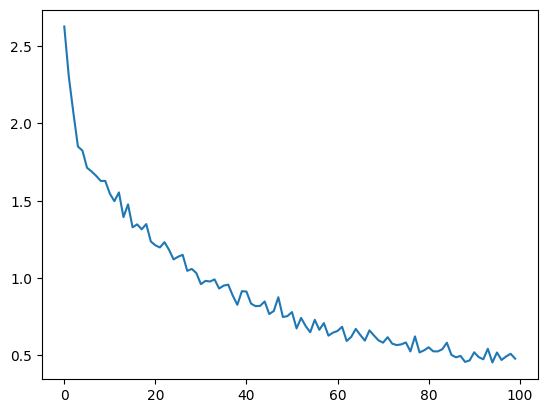

In [72]:

plt.figure()
plt.plot(all_losses)
plt.show()

/var/folders/6h/15ndlbdd5jl8rr8hqbhn5zz40000gn/T/ipykernel_93377/1400445024.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
/var/folders/6h/15ndlbdd5jl8rr8hqbhn5zz40000gn/T/ipykernel_93377/1400445024.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


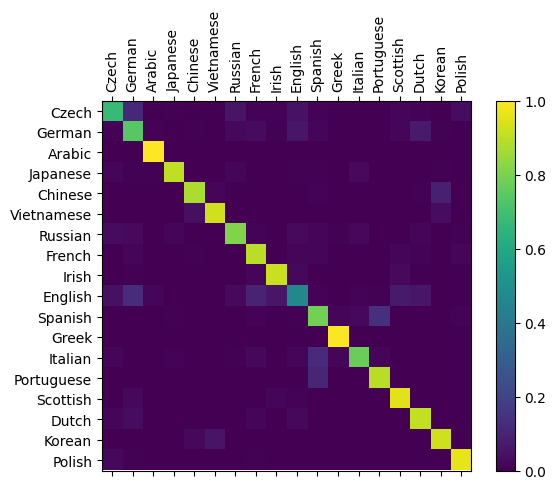

In [76]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
@torch.no_grad()
def evaluate(line_tensor):

    cl, _, _ = rnn_clf(line_tensor)

    return cl.unsqueeze(0)

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomSample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [79]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(name2tensor(input_line))
        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Minh Dung')


> Dovesky
(-0.40) Russian
(-1.17) Czech
(-4.30) English

> Jackson
(-0.11) Scottish
(-2.47) English
(-4.14) Russian

> Satoshi
(-0.01) Japanese
(-5.45) Arabic
(-7.81) Greek

> Minh Dung
(-0.06) Vietnamese
(-2.94) Chinese
(-5.98) Korean
